In [1]:
import pickle
import json
import os
from lang_sam import LangSAM
import torch
import matplotlib.pyplot as plt
import open3d as o3d
import cv2
from copy import deepcopy
from tqdm import tqdm
import argparse
import numpy as np
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from pyquaternion import Quaternion

from nuscenes.nuscenes import NuScenes, NuScenesExplorer
from nuscenes.utils.splits import create_splits_scenes
from nuscenes.utils.data_classes import LidarPointCloud, Box
from shapely.geometry import MultiPoint, box
from nuscenes.utils.geometry_utils import view_points, transform_matrix

import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/ayesha.ishaq/.conda/envs/sam3d/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
@ROTATED_DATASETS.register_module()
class LidarDataset(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('vehicle',)


In [3]:
# lidars = []
# colors = []
# filtered_lidars = []
# for i, mask in enumerate(masks):
    
#     if np.array(image).shape[:2] != mask.shape:
#         raise ValueError("Image and mask dimensions must be equal.")

#     # Extract mask indices
#     mask_indices = np.array(np.where(mask))

#     # Define a dtype with x and y integers    
#     arr1 = np.empty(projected_lidar_frame.shape[1], dtype=[('x', int), ('y', int)])
#     arr2 = np.empty(mask_indices.shape[1], dtype=[('x', int), ('y', int)])

#     # Add the data to the structured array
#     arr1['x'] = projected_lidar_frame[1, :].astype(int)
#     arr1['y'] = projected_lidar_frame[0, :].astype(int)

#     arr2['x'] = mask_indices[0, :]
#     arr2['y'] = mask_indices[1, :]
#     # Finding intersection
#     mask_points = np.in1d(arr1, arr2)

#     filtered_points = projected_lidar_frame[:2, mask_points]
#     filtered_lidar = lidar_points[:, mask_points]
#     filtered_colors = color[mask_points]
#     filtered_lidars.append(filtered_points)
#     lidars.append(filtered_lidar)
#     colors.append(filtered_colors)

#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_box(boxes[i], plt.gca())
#     plt.scatter(filtered_points[0, :], filtered_points[1, :], s=1, c='r') 
#     # plt.title(f"Mask {i+1}, Box: {i+1}", fontsize=18)
#     plt.axis('off')
#     plt.show()  



In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [5]:
# for i, lidar in enumerate(lidars):
    
#     color = colors[i]
#     averageValue_x = np.mean(lidar[0, :]) * 20
#     averageValue_y = np.mean(lidar[1, :]) * 20
#     print(averageValue_x, averageValue_y)

#     left_point = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([boxes[i][0], 0, 1]).copy().T)[[0, 2]]
#     right_point = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([boxes[i][2], 0, 1]).copy().T)[[0, 2]]

#     img = np.ones((700, 700, 3), 'f4')
#     img = img * 0.75
#     img = draw_point_clouds(img, color, lidar.T, averageValue_x, averageValue_y)
#     img = draw_frustum_lr_line(img, left_point, right_point, averageValue_x, averageValue_y)
#     # img = draw_bbox_3d_to_2d_gt(img, corners_3d.T, averageValue_x, averageValue_y)

#     plt.figure(figsize=(10,10))
#     plt.imshow(img)
#     # plt.title(f"gt {i+1}", fontsize=18)
#     plt.axis('off')
#     plt.show()  



In [6]:
# # Load the point cloud data from the NPY file
# # point_cloud_data = np.load("box1.npy")
# # print(point_cloud_data.shape)
# pc = lidars[2][:3, :].T

# # Create an Open3D PointCloud object
# # Create an Open3D PointCloud object
# pcd = o3d.geometry.PointCloud()

# # Convert the NumPy array to an Open3D Vector3dVector
# pcd.points = o3d.utility.Vector3dVector(pc)

# # Visualize the point cloud
# # p = [pcd] + bounding_boxes
# o3d.visualization.draw_geometries([pcd])

In [7]:
def map_pointcloud_to_image(nusc, pointsensor_token: str,
                            camera_token: str,
                            min_dist: float = 1.0):
        """
        Given a point sensor (lidar/radar) token and camera sample_data token, load pointcloud and map it to the image
        plane.
        :param pointsensor_token: Lidar/radar sample_data token.
        :param camera_token: Camera sample_data token.
        :param min_dist: Distance from the camera below which points are discarded.
        :return (pointcloud <np.float: 2, n)>, coloring <np.float: n>, image <Image>).
        """

        cam = nusc.get('sample_data', camera_token)
        pointsensor = nusc.get('sample_data', pointsensor_token)
        pcl_path = os.path.join(nusc.dataroot, pointsensor['filename'])
        pc = LidarPointCloud.from_file(pcl_path)
        im = Image.open(os.path.join(nusc.dataroot, cam['filename']))

        # world_point = deepcopy(pc.points)
        # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
        # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
        cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
        pc.translate(np.array(cs_record['translation']))

        # Second step: transform from ego to the global frame.
        poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
        pc.translate(np.array(poserecord['translation']))

        global_points = deepcopy(pc.points)

        # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
        poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
        pc.translate(-np.array(poserecord['translation']))
        pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

        # Fourth step: transform from ego into the camera.
        cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
        pc.translate(-np.array(cs_record['translation']))
        pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

        # Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]
        coloring = depths
      
        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

        # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
        # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
        # casing for non-keyframes which are slightly out of sync.
        mask = np.ones(depths.shape[0], dtype=bool)
        mask = np.logical_and(mask, depths > min_dist)
        mask = np.logical_and(mask, points[0, :] > 1)
        mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
        mask = np.logical_and(mask, points[1, :] > 1)
        mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
        points = points[:, mask]
        coloring = coloring[mask]
        # world_point = world_point[:, mask]
        pc_points = pc.points[:3,mask]

        return points, coloring, pc_points, global_points

In [8]:
dataset_dir = "/home/ayesha.ishaq/Desktop/3DMOTFormer/nuScenes/v1.0"

version_fullname = 'v1.0-trainval'
nusc = NuScenes(version=version_fullname, dataroot=dataset_dir, verbose=True)
# nusc_test = NuScenes(version='v1.0-test', dataroot=dataset_dir, verbose=True)
sequences_by_name = {scene["name"]: scene for scene in nusc.scene}
# sequences_by_name.update({scene["name"]: scene for scene in nusc_test.scene})
splits_to_scene_names = create_splits_scenes()

train_split = 'train' 
val_split = 'val' 
train_scenes = splits_to_scene_names[train_split]
val_scenes = splits_to_scene_names[val_split]
scenes = [train_scenes, val_scenes]




Loading NuScenes tables for version v1.0-trainval...


23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 37.838 seconds.
Reverse indexing ...
Done reverse indexing in 9.0 seconds.


In [9]:
model = LangSAM()

/home/ayesha.ishaq/.conda/envs/sam3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/ayesha.ishaq/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [30]:
scene = sequences_by_name[val_scenes[3]]
first_token = scene['first_sample_token']
last_token = scene['last_sample_token']
current_token = first_token
for i in range(20):
    current_sample = nusc.get('sample', current_token)
    next_token = current_sample['next']
    current_token = next_token
    break

In [11]:
def depth_to_color(depth, min_depth=1, max_depth=50, colormap="viridis"):
  """
  This function takes a depth value (between min_depth and max_depth) and maps it to a color
  using the specified colormap.

  Args:
    depth: The depth value (between min_depth and max_depth).
    min_depth: The minimum depth value (default is 1).
    max_depth: The maximum depth value (default is 100).
    colormap: The name of the colormap to use (default is "viridis").

  Returns:
    A list containing the RGB values of the mapped color.
  """

  # Normalize the depth value between 0 and 1
  normalized_depth = (depth - min_depth) / (max_depth - min_depth)

  # Import necessary libraries
  import matplotlib.cm as cm
  from matplotlib.colors import rgb2hex

  # Get the color from the chosen colormap
  color = cm.get_cmap(colormap)(normalized_depth)

  return color[:3]

In [12]:
def draw_point_clouds(img, colors, KeyPoint_for_draw, AverageValue_x, AverageValue_y):

    for i, point in enumerate(KeyPoint_for_draw):
        a = point[0] * 20 + 250 - AverageValue_x
        b = point[2] * 20 + 250 - AverageValue_y
        color = np.array(depth_to_color(colors[i]))*255
        cv2.circle(img, (int(a), int(b)), 1, color, 2)
    
    return img

In [13]:
def draw_frustum_lr_line(img, left_point, right_point, AverageValue_x, AverageValue_y):
    
    left_point_draw = np.array([0., 0.])
    left_point_draw[0] = (left_point[0] * 20000 + 250 - AverageValue_x)
    left_point_draw[1] = (left_point[1] * 20000 + 250 - AverageValue_y)

    right_point_draw = np.array([0., 0.])
    right_point_draw[0] = (right_point[0] * 20000 + 250 - AverageValue_x)
    right_point_draw[1] = (right_point[1] * 20000 + 250 - AverageValue_y)

    initial_point_draw = np.array([0., 0.])
    initial_point_draw[0] = 250 - AverageValue_x
    initial_point_draw[1] = 250 - AverageValue_y
    
    cv2.line(img, tuple(initial_point_draw.astype(np.int32)), tuple(left_point_draw.astype(np.int32)),
             (255, 0, 0), 1, 4)
    cv2.line(img, tuple(initial_point_draw.astype(np.int32)), tuple(right_point_draw.astype(np.int32)),
             (255, 0, 0), 1, 4)

    return img

In [14]:
def draw_bbox_3d_to_2d_gt(img, corner, AverageValue_x, AverageValue_y):
    
    gt_box_3d = corner.copy()
    for point in gt_box_3d:
        point[0] = point[0] * 20 + 250 - AverageValue_x
        point[1] = point[1] * 20 + 250 - AverageValue_y

    cv2.line(img, (int(gt_box_3d[0][0]), int(gt_box_3d[0][1])), (int(gt_box_3d[1][0]), int(gt_box_3d[1][1])), (255, 0, 0), 1, 4)
    cv2.line(img, (int(gt_box_3d[1][0]), int(gt_box_3d[1][1])), (int(gt_box_3d[5][0]), int(gt_box_3d[5][1])), (255, 0, 0), 1, 4)
    cv2.line(img, (int(gt_box_3d[5][0]), int(gt_box_3d[5][1])), (int(gt_box_3d[4][0]), int(gt_box_3d[4][1])), (255, 0, 0), 1, 4)
    cv2.line(img, (int(gt_box_3d[4][0]), int(gt_box_3d[4][1])), (int(gt_box_3d[0][0]), int(gt_box_3d[0][1])), (255, 0, 0), 1, 4)
    
    return img

In [15]:
def calculate_height(top_1, top_2, bot_1, bot_2, keypoint):

    # calculate the [vertical] height in frustum at key vertex (input variable [keypoint])

    # because top and bottom plane of frustum crosses (0, 0, 0), we assume the plane equation: Ax + By + 1 * z = 0
    # |x1 y1| |A|     |-1|         |A|     |x1 y1| -1    |-1|
    # |     | | |  =  |  |     =>  | |  =  |     |    *  |  |
    # |x2 y2| |B|     |-1|         |B|     |x2 y2|       |-1|

    mat_1 = np.array([[top_1[0], top_1[1]], [top_2[0], top_2[1]]])
    mat_2 = np.array([[bot_1[0], bot_1[1]], [bot_2[0], bot_2[1]]])
    mat_3 = np.array([-1., -1.]).T

    top_plane_info = np.linalg.inv(mat_1).dot(mat_3)
    bot_plane_info = np.linalg.inv(mat_2).dot(mat_3)

    top_y = -1 * (keypoint[0] * top_plane_info[0] + keypoint[1] * 1) / top_plane_info[1]
    bot_y = -1 * (keypoint[0] * bot_plane_info[0] + keypoint[1] * 1) / bot_plane_info[1]

    return top_y, bot_y


In [16]:
def initialize_bev_detector(cfg_file, ckpoint):
    # Choose to use a config and initialize the detector
    config = cfg_file
    # Setup a checkpoint file to load
    checkpoint = ckpoint
    # Set the device to be used for evaluation
    device='cuda:0'
    # Load the config
    config = mmcv.Config.fromfile(config)
    # Set pretrained to be None since we do not need pretrained model here
    config.model.pretrained = None
    # Initialize the detector
    model = build_detector(config.model)
    # Load checkpoint
    checkpoint = load_checkpoint(model, checkpoint, map_location=device)
    # Set the classes of models for inference
    model.CLASSES = checkpoint['meta']['CLASSES']
    # We need to set the model's cfg for inference
    model.cfg = config
    # Convert the model to GPU
    model.to(device)
    # Convert the model into evaluation mode
    model.eval()
    return model


In [17]:
# Choose to use a config and initialize the detector
cfg = '/home/ayesha.ishaq/mmrotate/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = '/home/ayesha.ishaq/mmrotate/epoch_3.pth'
orientedrcnn_model = initialize_bev_detector(cfg, checkpoint)

/home/ayesha.ishaq/.conda/envs/sam3d/lib/python3.9/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /home/ayesha.ishaq/mmrotate/epoch_3.pth


In [25]:
veh = ["car","truck","bus","trailer","construction vehicle","motorcycle","bicycle"]
veh = ["vehicle"]

In [19]:
def get_box_lidar(box, nusc, pointsensor_token: str,
                            camera_token: str):
    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)

    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    box.rotate(Quaternion(cs_record['rotation']))
    box.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    box.rotate(Quaternion(poserecord['rotation']))
    box.translate(np.array(poserecord['translation']))

    # # Third step: transform from global into the ego vehicle frame for the timestamp of the lidar.
    # poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    # box.translate(-np.array(poserecord['translation']))
    # box.rotate(Quaternion(poserecord['rotation']).inverse)

    # # Fourth step: transform from ego into the camera.
    # cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    # box.translate(-np.array(cs_record['translation']))
    # box.rotate(Quaternion(cs_record['rotation']).inverse)

    return box.corners()

In [20]:
import time

mask time 1.0323095321655273
0.7768343091011047 <class 'float'>


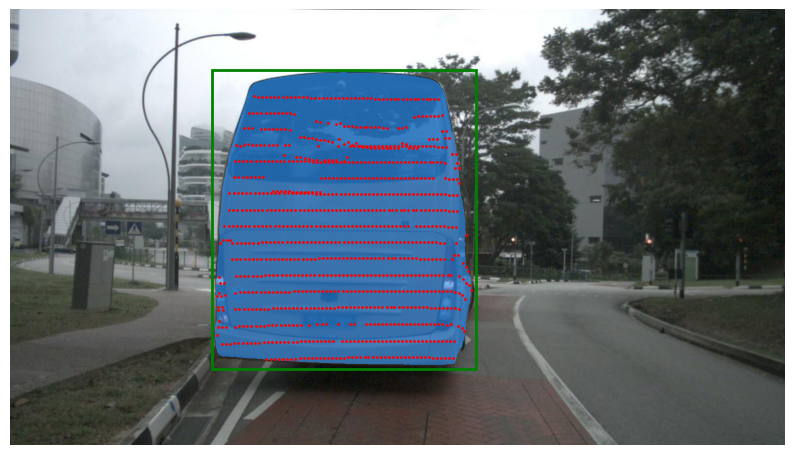

/tmp/slurm-ayesha.ishaq-26241/ipykernel_1574212/1974717159.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = cm.get_cmap(colormap)(normalized_depth)


ORCNN time 0.08557248115539551


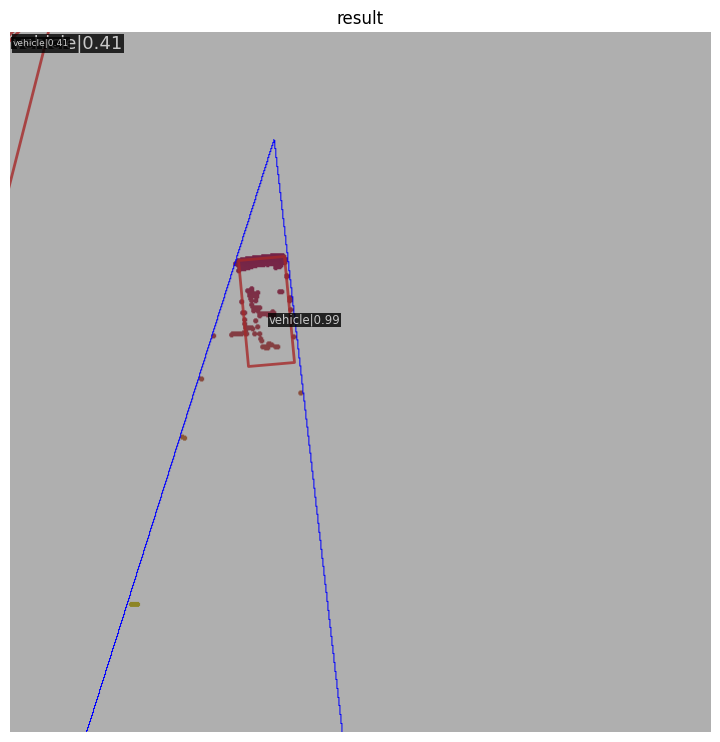

CAM_FRONT 256.6415 279.2867 106.51261 46.286274 1.4744846 0.9861886
5.325630569458008 2.3143136978149412
0.33790040016174316 <class 'float'>


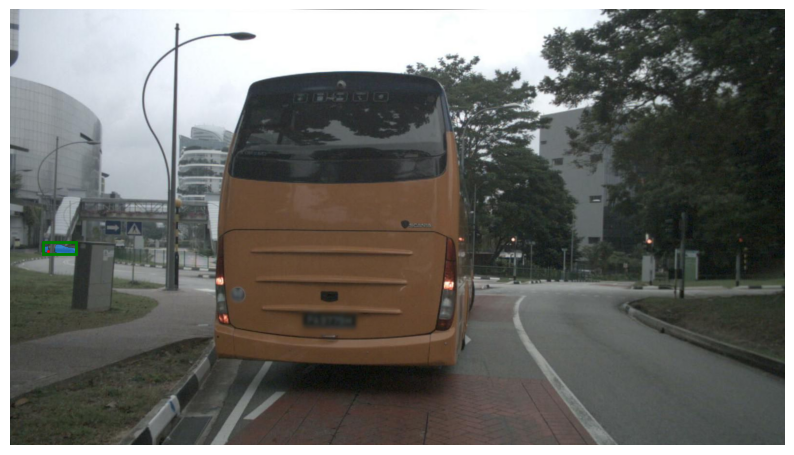

ORCNN time 0.09512591361999512


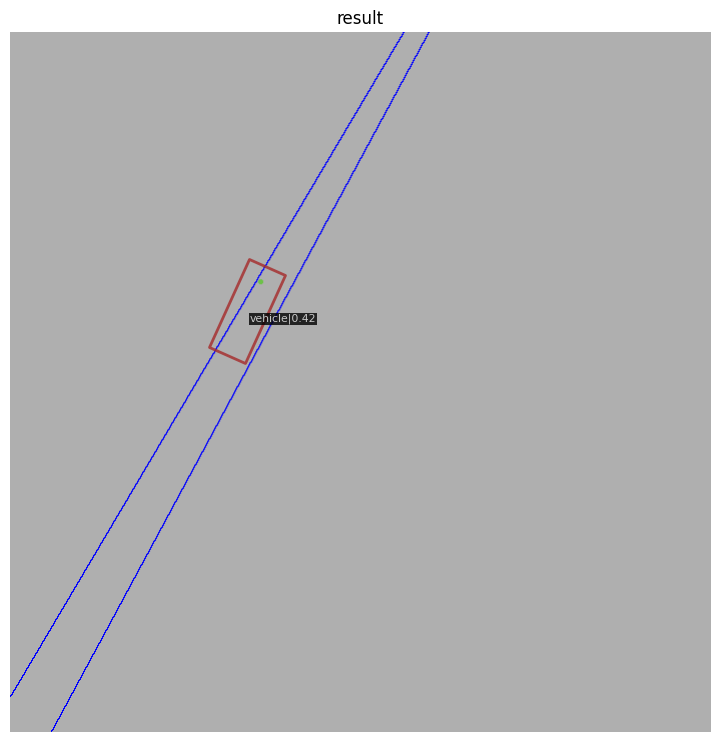

CAM_FRONT 237.36377 279.4666 97.24856 39.330307 -1.1421589 0.41669077
4.86242790222168 1.966515350341797
mask time 0.9235327243804932
0.5810563564300537 <class 'float'>


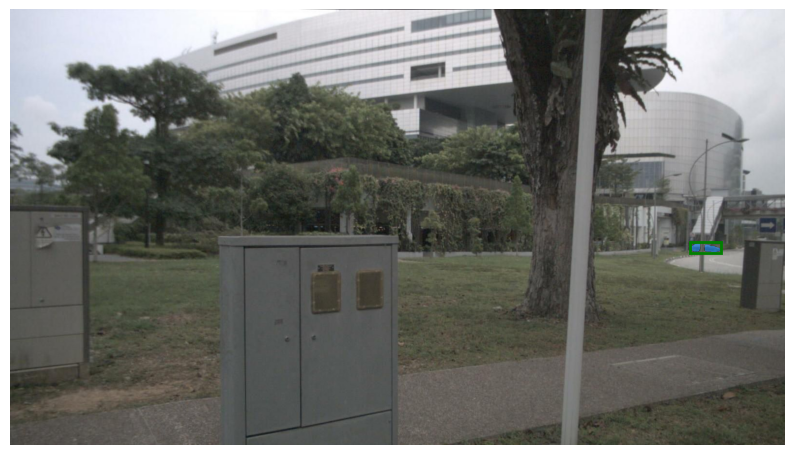

/tmp/slurm-ayesha.ishaq-26241/ipykernel_1574212/2018211686.py:15: RuntimeWarning: invalid value encountered in cast
  cv2.line(img, tuple(initial_point_draw.astype(np.int32)), tuple(left_point_draw.astype(np.int32)),
/tmp/slurm-ayesha.ishaq-26241/ipykernel_1574212/2018211686.py:17: RuntimeWarning: invalid value encountered in cast
  cv2.line(img, tuple(initial_point_draw.astype(np.int32)), tuple(right_point_draw.astype(np.int32)),


ORCNN time 0.08797574043273926


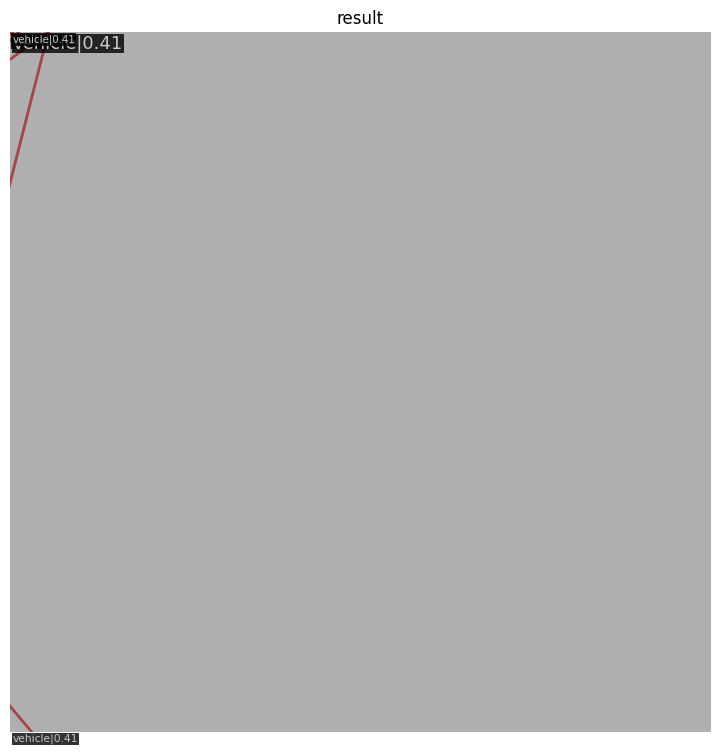

CAM_FRONT_LEFT 237.36377 279.4666 97.24856 39.330307 -1.1421589 0.41669077
4.86242790222168 1.966515350341797


AssertionError: 

In [31]:
# Get ego pose data
current_sample = nusc.get('sample', current_token)
lidar_top_data = nusc.get('sample_data', current_sample['data']['LIDAR_TOP'])
ego_pose_lidar = nusc.get('ego_pose', lidar_top_data['ego_pose_token'])
ego_trans_lidar = np.array(ego_pose_lidar['translation'], dtype=np.float32)
ego_rot_lidar = Quaternion(ego_pose_lidar['rotation'])
lidar_transform = nusc.get('calibrated_sensor', lidar_top_data['calibrated_sensor_token'])
text_prompt = "vehicle"
cameras = ["CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT", "CAM_BACK", "CAM_BACK_LEFT", "CAM_BACK_RIGHT"]
device = "cuda" if torch.cuda.is_available() else "cpu"
# frame_ann_tokens = current_sample['anns']
# for i, ann_token in enumerate(frame_ann_tokens):
#     ann = nusc.get('sample_annotation', ann_token)
#     if ann['category_name'].split('.')[0] == 'vehicle':
#         # get 2D bounding box for gt
#         box = Box(ann['translation'],
#                     ann['size'], 
#                     Quaternion(ann['rotation']))
        
#         corners_3d = box.corners()
#         with open('corners_gt_{}.npy'.format(i), 'wb') as f:
#             np.save(f, np.array(corners_3d))
for cam in cameras:
    camera = nusc.get('sample_data', current_sample['data'][cam])
    camera_transform = nusc.get('calibrated_sensor', camera['calibrated_sensor_token'])
    camera_intrinsic = camera_transform['camera_intrinsic']
    img_path = os.path.join(nusc.dataroot, camera['filename'])
    ego_pose_cam = nusc.get('ego_pose', camera['ego_pose_token'])
    image = Image.open(img_path).convert("RGB")
    projected_lidar_frame, color, lidar_points_cam, lidar_points  = map_pointcloud_to_image(nusc, current_sample['data']['LIDAR_TOP'],
        current_sample['data'][cam])

    # with open('LIDAR_{}.npy'.format(cam), 'wb') as f:
    #     np.save(f, lidar_points)
    for prompt in veh:
        start = time.time()
        masks, boxes, phrases, logits = model.predict(image, prompt)
        end = time.time()
        print("mask time", end-start)
        for i, mask in enumerate(masks):
            print(float(logits[i]), type(float(logits[i])))
            if np.array(image).shape[:2] != mask.shape:
                raise ValueError("Image and mask dimensions must be equal.")

            # Extract mask indices
            mask_indices = np.array(np.where(mask))

            # Define a dtype with x and y integers    
            arr1 = np.empty(projected_lidar_frame.shape[1], dtype=[('x', int), ('y', int)])
            arr2 = np.empty(mask_indices.shape[1], dtype=[('x', int), ('y', int)])

            # Add the data to the structured array
            arr1['x'] = projected_lidar_frame[1, :].astype(int)
            arr1['y'] = projected_lidar_frame[0, :].astype(int)

            arr2['x'] = mask_indices[0, :]
            arr2['y'] = mask_indices[1, :]
            # Finding intersection
            mask_points = np.in1d(arr1, arr2)

            filtered_points = projected_lidar_frame[:2, mask_points]
            filtered_lidar = lidar_points_cam[:, mask_points]
            filtered_colors = color[mask_points]

            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_mask(mask, plt.gca())
            show_box(boxes[i], plt.gca())
            plt.scatter(filtered_points[0, :], filtered_points[1, :], s=1, c='r') 
            # plt.title(f"Mask {i+1}, Box: {i+1}", fontsize=18)
            plt.axis('off')
            plt.show()  

            averageValue_x = np.mean(filtered_lidar[0, :]) * 20
            averageValue_y = np.mean(filtered_lidar[2, :]) * 20
        
            x0, y0, x1, y1 = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            left_point = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([x0, 0, 1]).copy().T)[[0, 2]]
            right_point = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([x1, 0, 1]).copy().T)[[0, 2]]
            mat_1 = np.array([[left_point[0], right_point[0]], [left_point[1], right_point[1]]])

            img = np.ones((700, 700, 3), 'f4')
            img = img * 175
            img = draw_point_clouds(img, filtered_colors, filtered_lidar.T, averageValue_x, averageValue_y)
            img = draw_frustum_lr_line(img, left_point, right_point, averageValue_x, averageValue_y)
            start = time.time()
            bev_result = inference_detector(orientedrcnn_model, img) # highest score detection
            end = time.time()
            print('ORCNN time', end-start)
            show_result_pyplot(orientedrcnn_model, img, bev_result, score_thr=0.2, palette='dota')
            for result in bev_result:
                for each in result:
                    if each[0] == 0 or each[1] == 0:
                        continue
                    else:
                        center_x = (each[0] + averageValue_x - 250)/20
                        center_y = (each[1] + averageValue_y - 250)/20
                        width = each[2]/20
                        length = each[3]/20
                        angle = -each[4]
                        xc, yc, w, h, ag, conf = each[:6]
                        break
            print(cam, xc, yc, w, h, ag, conf)
            wx, wy = w / 2 * np.cos(ag), w / 2 * np.sin(ag)
            hx, hy = -h / 2 * np.sin(ag), h / 2 * np.cos(ag)
            p_x = ((xc - wx - hx)+ averageValue_x - 250)/20
            p_y = ((yc - wy - hy) + averageValue_y - 250)/20
            # p2_x = ((xc + wx - hx)+ averageValue_x - 250)/20
            # p2_y = ((yc + wy - hy) + averageValue_y - 250)/20
            # p3_x = ((xc + wx + hx)+ averageValue_x - 250)/20
            # p3_y = ((yc + wy + hy) + averageValue_y - 250)/20
            # p4_x = ((xc - wx + hx)+ averageValue_x - 250)/20
            # p4_y = ((yc - wy + hy) + averageValue_y - 250)/20
            # print(w/20, h/20)
            # width = distance_between_points(p_x, p_y, p2_x, p2_y)
            # length = distance_between_points(p3_x, p3_y, p2_x, p2_y)
            print(width, length)

            top_1 = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([x0, y0, 1]).T)
            top_2 = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([x1, y0, 1]).T)
            bot_1 = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([x0, y1, 1]).T)
            bot_2 = np.linalg.inv(np.array(camera_intrinsic)).dot(np.array([x1, y1, 1]).T)

            y_min, y_max = calculate_height(top_1, top_2, bot_1, bot_2, [p_x, p_y])
            height = abs(y_max - y_min)
            center_z = (y_max + y_min)/2

            center = np.array([center_x, center_z, center_y])
            size = np.array([height, width, length])
            box = Box(center,
                size, 
                Quaternion(axis=[0, -1, 0], angle=-angle))
            # corners_3d = np.array([[p_x, p2_x, p2_x, p_x, p4_x, p3_x, p3_x, p4_x],
            #         [y_min, y_min, y_max, y_max, y_min, y_min, y_max, y_max],
            #         [p_y, p2_y, p2_y, p_y, p4_y, p3_y, p3_y, p4_y]
            #         ])

            corners_3d = get_box_lidar(box, nusc,current_sample['data']['LIDAR_TOP'], current_sample['data'][cam])
            corners_3d_box = box.corners()
            # with open('corners_{}_{}.npy'.format(i, cam), 'wb') as f:
            #     np.save(f, np.array(corners_3d))


In [22]:
print(type(logits))

<class 'torch.Tensor'>


In [23]:
logits

tensor([])

In [24]:
python evaluate.py --dataset_dir /home/ayesha.ishaq/Desktop/3DMOTFormer/nuScenes/ --checkpoint '/home/ayesha.ishaq/mmrotate/epoch_3.pth' --config '/home/ayesha.ishaq/mmrotate/oriented_rcnn_r50_fpn_1x_dota_le90.py' --output_dir /home/ayesha.ishaq/Desktop/Geometric3DBBox 

SyntaxError: invalid syntax (3412970741.py, line 1)